In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [156]:
# Read train data
train_data = pd.read_csv('./data/train.csv')

In [134]:
# Explatory data analysis
train_data.head()
train_data.shape
train_data.ndim
train_data.columns
train_data.info()
train_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


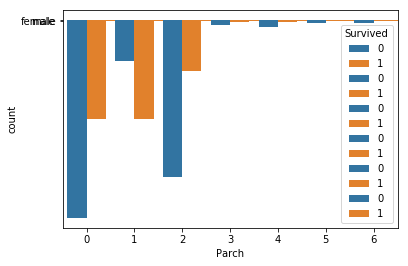

In [127]:
# Data visualization

# By plotting a count plot of passenger class with respect to Survived, we can see that class is highly correlated with the survival 
# (most of first class passengers survived)
sns.countplot(x='Pclass', hue='Survived', data=train_data)

# Sex vs Survived shows larger portion of females survived compared to males
sns.countplot(x='Sex', hue='Survived', data=train_data)

sns.barplot(x='Age', y='Sex', hue='Survived', data=train_data)
sns.countplot(x='Embarked', hue='Survived', data=train_data)
sns.countplot(x='SibSp', hue='Survived', data=train_data)
sns.countplot(x='Parch', hue='Survived', data=train_data)

In [135]:
# Data cleaning

def get_nan(data, feature):
    return data[data[feature].isnull()]

def print_nan(data):
    for feature in data.columns:
        print('{0}: {1}'.format(feature, len(get_nan(data, feature))))

print('NaN values before cleaning')
# As we can see from the results, we have some missing data for Age, Cabin and Embarked.
print_nan(train_data)

NaN values before cleaning
PassengerId: 0
Survived: 0
Pclass: 0
Name: 0
Sex: 0
Age: 177
SibSp: 0
Parch: 0
Ticket: 0
Fare: 0
Cabin: 687
Embarked: 2


In [157]:
def process_name():
    global train_data
    train_data.drop('Name', axis=1, inplace=True)

process_name()

In [158]:
def process_sex():
    global train_data
    train_data = train_data.replace({'male': 0, 'female': 1})

process_sex()

In [159]:
def process_ticket():
    global train_data
    train_data.drop('Ticket', axis=1, inplace=True)

process_ticket()

In [160]:
# Cabin has NaN for most of the rows, so we can drop this column
def process_cabin():
    global train_data
    train_data.drop('Cabin', axis=1, inplace=True)

process_cabin()

In [161]:
# For Embarked, we have 2 missing values, lets just replace them with most common embarking point which is S
def process_embarked():
    global train_data
    counts = train_data.Embarked.value_counts()
    train_data['Embarked'].fillna(counts[counts == counts.max()].index.values[0], inplace=True)
    embarked_dummies = pd.get_dummies(train_data['Embarked'], prefix='Embarked')
    train_data = pd.concat([train_data, embarked_dummies], axis=1)
    train_data.drop('Embarked', axis=1, inplace=True)

process_embarked()

In [162]:
# Age is an important feature as we can tell from the graphs. So it would be better to keep it.
# We can replace it with the mean/median of the age, but that would be problematic as ages might differ depending on people's classes
# Therefore, best way would be to assign the age based on Pclass and Sex of the person
grouped_data = train_data.groupby(['Sex', 'Pclass'])
grouped_data_median = grouped_data.median().reset_index()

def get_age(row):
    condition = (grouped_data_median['Pclass'] == row['Pclass']) & (grouped_data_median['Sex'] == row['Sex'])

    if np.isnan(row['Age']):
        return grouped_data_median[condition]['Age'].values[0]
    else:
        return row['Age']

def process_age():
    global train_data
    train_data['Age'] = train_data.apply(lambda row: get_age(row), axis=1)
    
process_age()

In [151]:
# Let's look at Fare distribution with respect to Survived
# Since fare is a continuous variable, we can group it in ranges
# First, we find its median and create ranges around that. (median is 14.)
def get_range(fare):
    if fare < 5: return '0-5'
    if fare < 10: return '5-10'
    if fare < 15: return '10-15'
    if fare < 100: return '15-100'
    if fare < 200: return '100-200'
    if fare < 300: return '200-300'
    if fare < 400: return '300-400'
    return '400'

def process_fare():
    global train_data
    train_data['FareRange'] = train_data['Fare'].map(get_range)
    sns.countplot(x='FareRange', hue='Survived', data=train_data)
#     fare_dummies = pd.get_dummies(train_data['FareRange'], prefix='FareRange')
#     train_data = pd.concat([train_data, fare_dummies], axis=1)
    train_data.drop('FareRange', axis=1, inplace=True)

# We see people who paid had better chance of surviving
process_fare()

ValueError: Could not interpret input 'FareRange'

In [163]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked_C     891 non-null uint8
Embarked_Q     891 non-null uint8
Embarked_S     891 non-null uint8
dtypes: float64(2), int64(6), uint8(3)
memory usage: 58.4 KB


In [164]:
# Let's build our first model based on features that we think are important to the model
# we will use Gaussian Naive Bayes model for this
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def run_model(model, data):
    feature_data = data[list(set(data.columns) - set(['Survived']))]
    label_data = data.Survived
    features_train, features_test, labels_train, labels_test = train_test_split(feature_data, label_data, test_size=0.3, random_state=42)
    
    model.fit(features_train, labels_train)
    predictions = model.predict(features_test)
    accuracy = accuracy_score(labels_test, predictions)
    report = classification_report(labels_test, predictions)
    confusion = confusion_matrix(labels_test, predictions)
    return (accuracy, report, confusion)

In [165]:
# We get 79% accuracy on this model
from sklearn.naive_bayes import GaussianNB
model = GaussianNB() 
results = run_model(model, train_data)
for score in results: print(score)

0.7910447761194029
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       157
           1       0.75      0.75      0.75       111

   micro avg       0.79      0.79      0.79       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268

[[129  28]
 [ 28  83]]


In [168]:
# Now let's use Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150, min_samples_leaf=3)
run_model(model, train_data)
for score in results: print(score)

0.7910447761194029
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       157
           1       0.75      0.75      0.75       111

   micro avg       0.79      0.79      0.79       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268

[[129  28]
 [ 28  83]]
